In [1]:
from selenium import webdriver
from fake_useragent import UserAgent
import time

In [2]:
class Movie:
    
    URL = "https://movie.naver.com/movie/running/current.nhn"
    
    def __init__(self, url=URL, headless=False):
        self.options = webdriver.ChromeOptions()
        self.options.add_argument("user-agent={}".format(UserAgent().chrome))
        if headless:
            self.options.add_argument('headless')
        self.driver = webdriver.Chrome(options=self.options)
        self.url = url
        self.rows = []
        self.columns = ["평점", "댓글", "공감수", "비공감수"]
        self.values = None
        self.result_df = None

    
    # 입력된 title값을 변수로 받아 영화 검색
    def __input_title(self, movieName):
        self.driver.find_element_by_css_selector("#ipt_tx_srch").send_keys(movieName)
        self.driver.find_element_by_css_selector("#jSearchArea div button").click()
        time.sleep(1)
        
    
    # page를 변수로 받아 원하는 page까지 댓글 수집
    def __collecting(self, page):
        self.driver.find_element_by_css_selector("#cbody > #old_content ul.search_list_1 > li > p > a").click()
        time.sleep(1)
        self.driver.find_element_by_css_selector("div.score.score_left > div.star_score  > a").click()
        time.sleep(1)
        
        i = 1
        while True:
            self.driver.execute_script("window.scrollTo(0, 2500);")
            if i == 1 :
                iframe = self.driver.find_element_by_css_selector("#pointAfterListIframe")
                self.driver.switch_to_frame(iframe)

            datguls = self.driver.find_elements_by_css_selector("div.input_netizen  > div.score_result > ul li")

            # 평점,댓글,공감수,비공감수 크롤링
            for datgul in datguls:
                row = []
                score = datgul.find_element_by_css_selector("div.star_score > em").text
                text = datgul.find_element_by_css_selector("div.score_reple > p").text
                gong = datgul.find_element_by_css_selector("div.btn_area > strong:nth-child(2) > span").text
                bigong = datgul.find_element_by_css_selector("div.btn_area > strong:nth-child(4) > span").text
                row.append(score)
                row.append(text)
                row.append(gong)
                row.append(bigong)
                self.rows.append(row)
            
            i += 1
            if i == page + 1:
                break
            else:
                self.driver.find_element_by_css_selector("#pagerTagAnchor{} > em".format(i)).click()
        
    
    # movieName, page를 변수로 받으면 검색해주는 함수 : user용 함수
    def crawling(self, movieName, page=10, headless=False):
        self.driver.get(self.url)
        self.__input_title(movieName)        
        self.__collecting(page)        
        return pd.DataFrame(self.rows, columns=self.columns)

In [3]:
# testcode
movie = Movie()

1 page 당 10개의 댓글

In [4]:
df = movie.crawling("해리포터")
df.tail()

,평점,댓글,공감수,비공감수
95,10,다시봐도 최고~~ 아빠랑 형이랑 손잡고 이거보러가던 생각난다 ㅎㅎㅎ먼가 기분이 좋아...,5,0
96,10,16년이 지난 지금도 소장하고 보고있는데 처음 나오는 그 배경음악 벨소리로 할 정도...,6,1
97,10,평가를 할 수 없는 최고의 작품!!! 판타지 중에서는 가장 으뜸으로 해주고 싶은 최...,6,1
98,10,정말 비록 태어나기전에 이영화가 나왔지만 시리즈를다보고 정말 대작이라는것을 느꼈다....,6,1
99,10,꼭 보러간다 나의 어린 시절 기다려라 ㅠㅠㅠㅠ 향수가 생긴다,7,2


In [5]:
df.shape

(100, 4)

100개 확인

## Word Cloud 생성

In [6]:
comments = df["댓글"]
comments.head()

0    설렘을 준 영화. 그 어린 나이에 즐거운 상상을 하게 해준. 판타지의 시작. 지금은...
1                                               전설의 시작
2    전 이 영화를 잊지않을겁니다. 영원히요. 그리고, 제겐 역대 최고의 영화로 남을지도...
3                                       이때로 돌아가고 싶다...
4                                         애들 너무 귀여워 ㅠㅠ
Name: 댓글, dtype: object

In [7]:
sentences = [comments.loc[i] for i in range(len(comments))]
print(sentences[:5] ,type(sentences))

['설렘을 준 영화. 그 어린 나이에 즐거운 상상을 하게 해준. 판타지의 시작. 지금은 추억이 되어버렸다는게 믿기힘들정도로 내 삶의 큰 부분을 차지했었던 영화. 해리포터 개봉날은 연중행사였어...', '전설의 시작', '전 이 영화를 잊지않을겁니다. 영원히요. 그리고, 제겐 역대 최고의 영화로 남을지도;;;? 모르겠네요.', '이때로 돌아가고 싶다...', '애들 너무 귀여워 ㅠㅠ'] <class 'list'>


In [8]:
#stences를 string 형식으로 형변환
re_sentences=str(sentences)
print(re_sentences[:100], type(re_sentences))

['설렘을 준 영화. 그 어린 나이에 즐거운 상상을 하게 해준. 판타지의 시작. 지금은 추억이 되어버렸다는게 믿기힘들정도로 내 삶의 큰 부분을 차지했었던 영화. 해리포터 개봉날은  <class 'str'>


In [9]:
#KoNLPy Mecab사용
from konlpy.tag import Mecab #konlpy, Mecap Module

In [10]:
#형태소 분석기로 명사만 추출
#글자가 1개인 것은 의미가 없다고 봐서 삭제
engine = Mecab()
nouns = engine.nouns(re_sentences)
nouns = [n for n in nouns if len(n) > 1] # 1 글자 단어는 삭제

In [11]:
len(nouns)

429

In [12]:
nouns[:20]

['영화',
 '나이',
 '상상',
 '판타지',
 '시작',
 '추억',
 '정도',
 '부분',
 '차지',
 '영화',
 '해리포터',
 '개봉',
 '연중행사',
 '전설',
 '시작',
 '영화',
 '겁니다',
 '제겐',
 '역대',
 '최고']

In [13]:
#Counter로 단어의 개수 세기
#Counter.most_common() = 가장 많이 등장한 N개 구함
from collections import Counter
count = Counter(nouns)
tags = count.most_common(100)
# "영화" 단어는 제외하기
if tags[0][0] == "영화":
    del tags[0]
tags[:20]

[('해리포터', 24),
 ('최고', 18),
 ('시리즈', 11),
 ('추억', 8),
 ('마법사', 7),
 ('판타지', 6),
 ('시작', 5),
 ('인생', 5),
 ('오랜만', 4),
 ('기억', 4),
 ('생각', 4),
 ('지금', 4),
 ('사랑', 4),
 ('상상', 3),
 ('정도', 3),
 ('개봉', 3),
 ('역대', 3),
 ('사람', 3),
 ('그때', 3),
 ('작품', 3)]

In [14]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

<IPython.core.display.Javascript object>


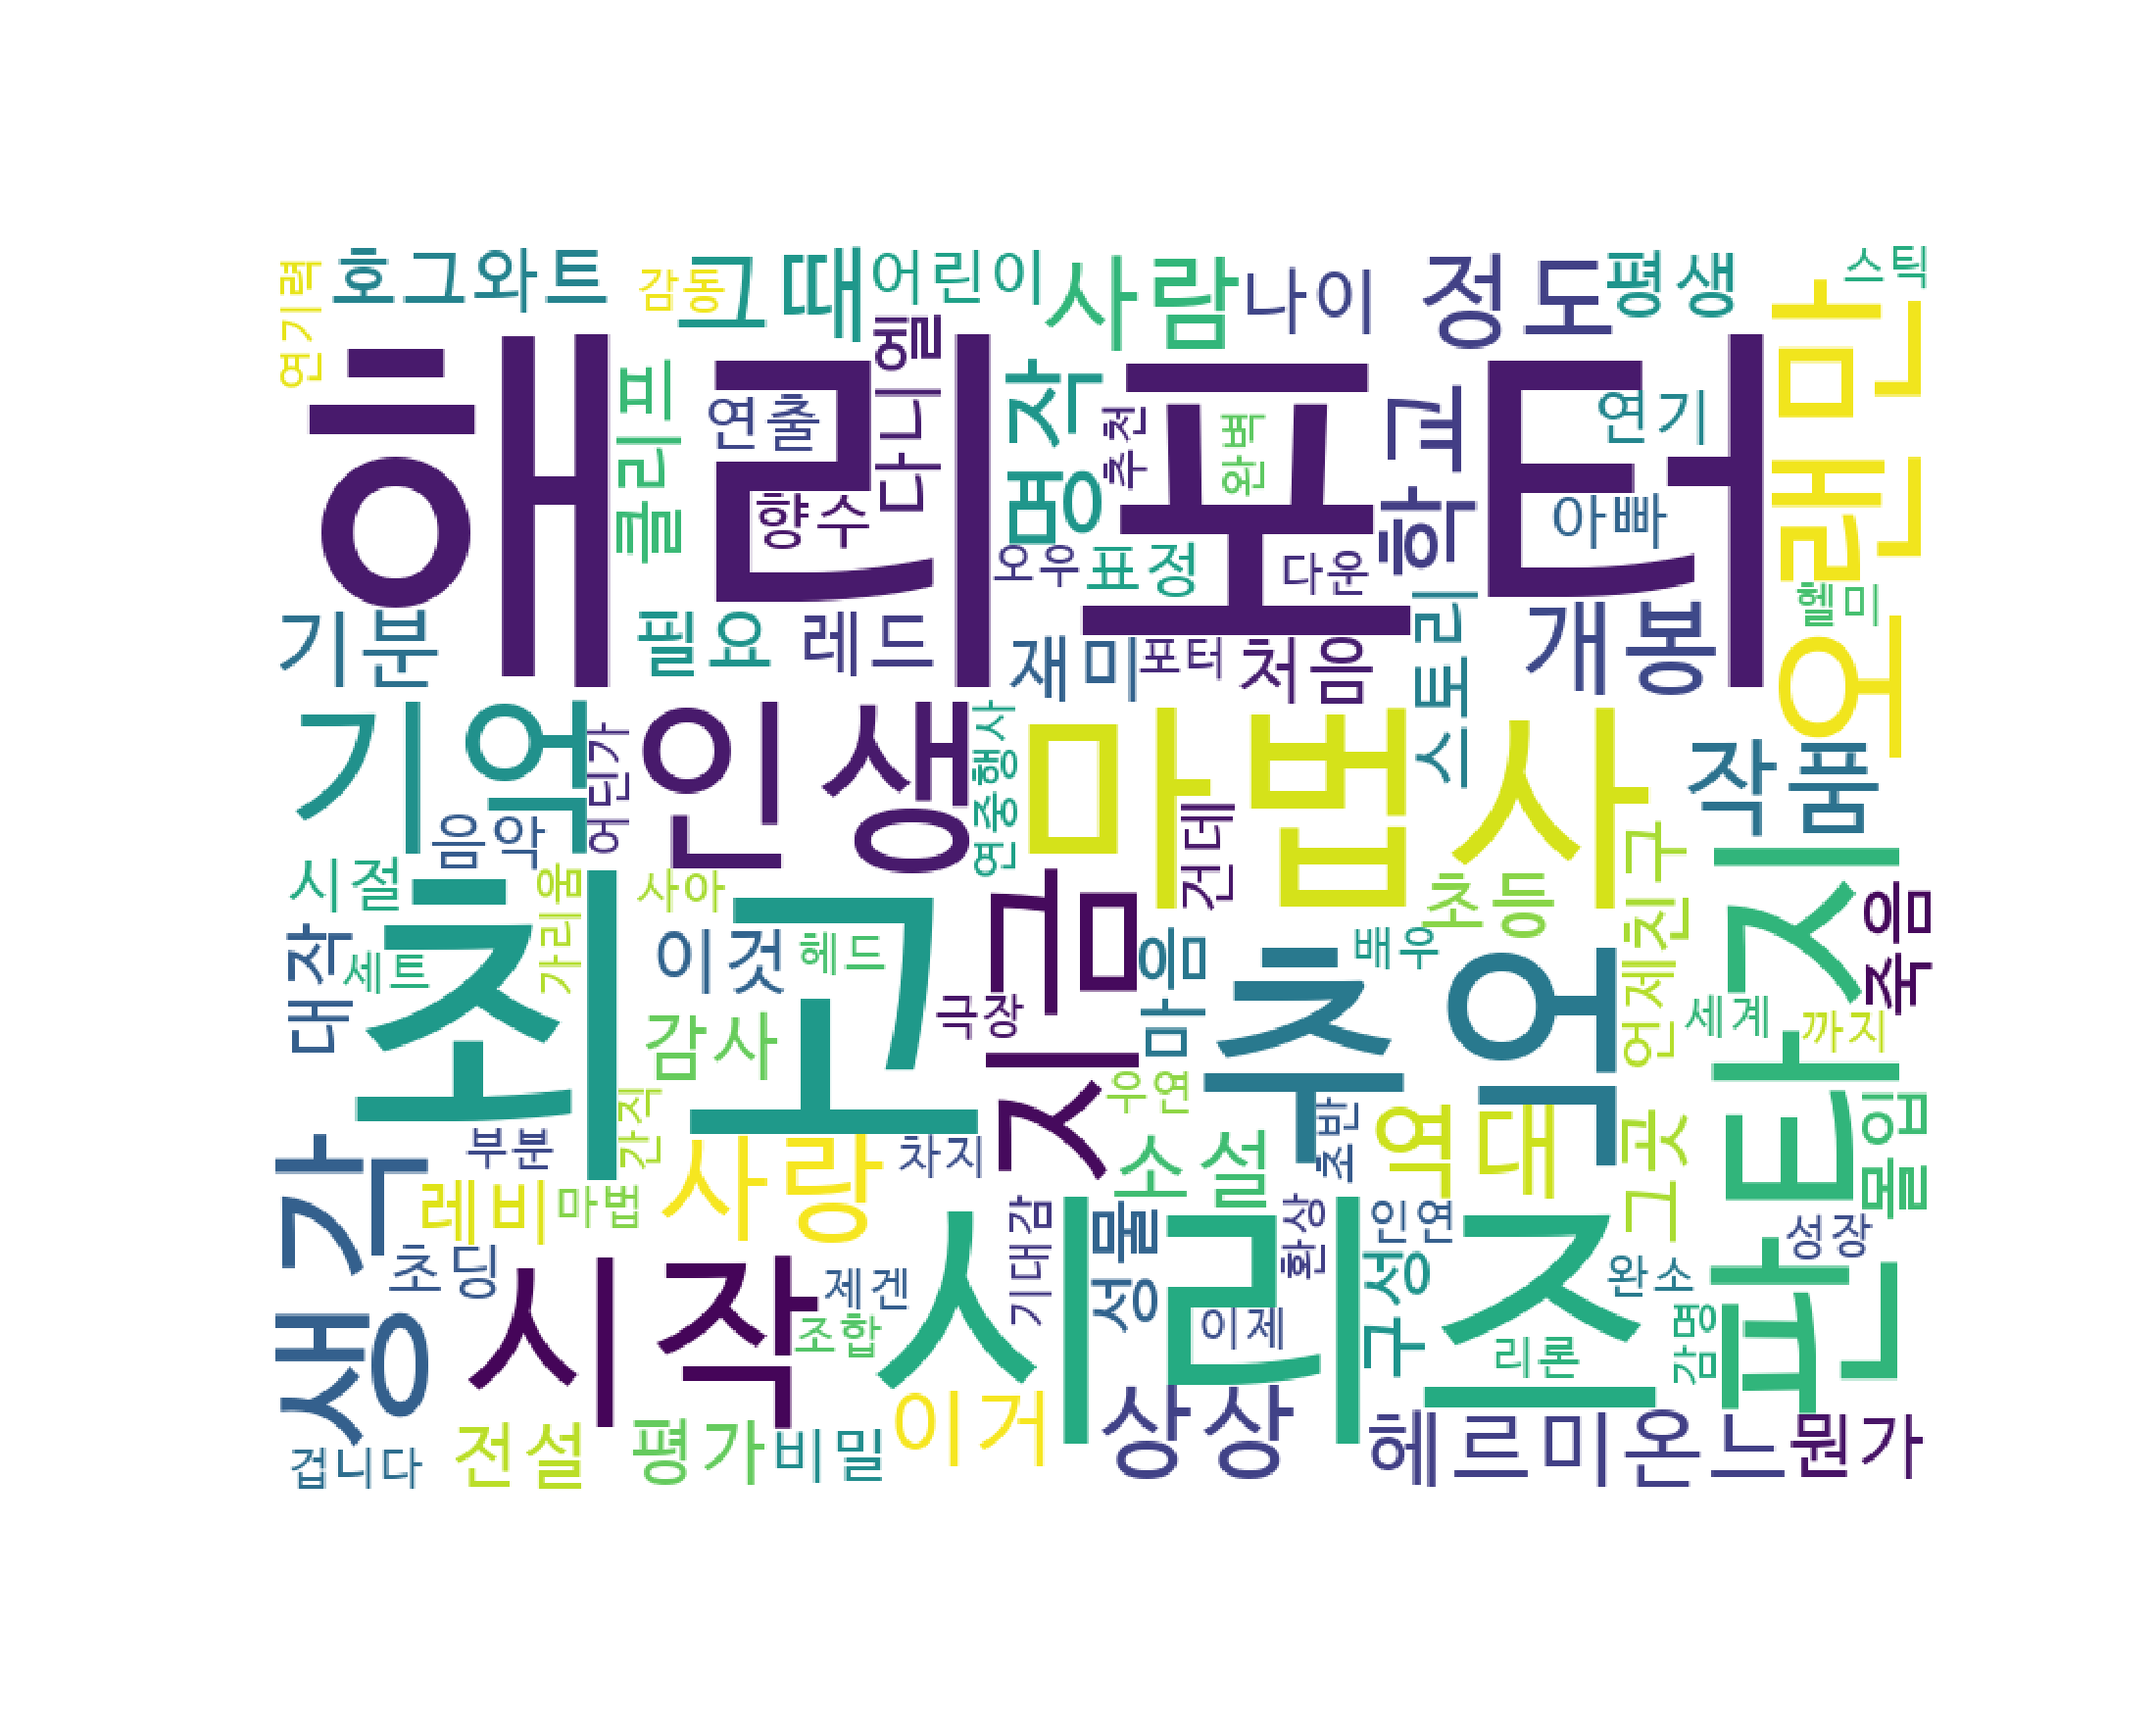

In [15]:
font_path = '/D2Coding.ttc'
# plot the WordCloud image 
wc = WordCloud(font_path=font_path, background_color='white', width=800, height=600)
cloud = wc.generate_from_frequencies(dict(tags))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)